# Carga de datos

In [1]:
!pip install medmnist --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

import numpy as np
import matplotlib.pyplot as plt
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras
keras.utils.set_random_seed(23)

In [3]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download)
val_dataset = DataClass(split='val', download=download)
test_dataset = DataClass(split='test', download=download)

# encapsulate data into dataloader form
#train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 32657349/32657349 [00:02<00:00, 12034806.62it/s]


Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz


In [4]:
import warnings; warnings.filterwarnings('ignore'); from sklearn.metrics import accuracy_score

In [5]:
import numpy as np

x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)

labels = list(train_dataset.info["label"].values())
num_classes = len(labels)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(971, 28, 28, 28) (971, 1) (610, 28, 28, 28) (610, 1)


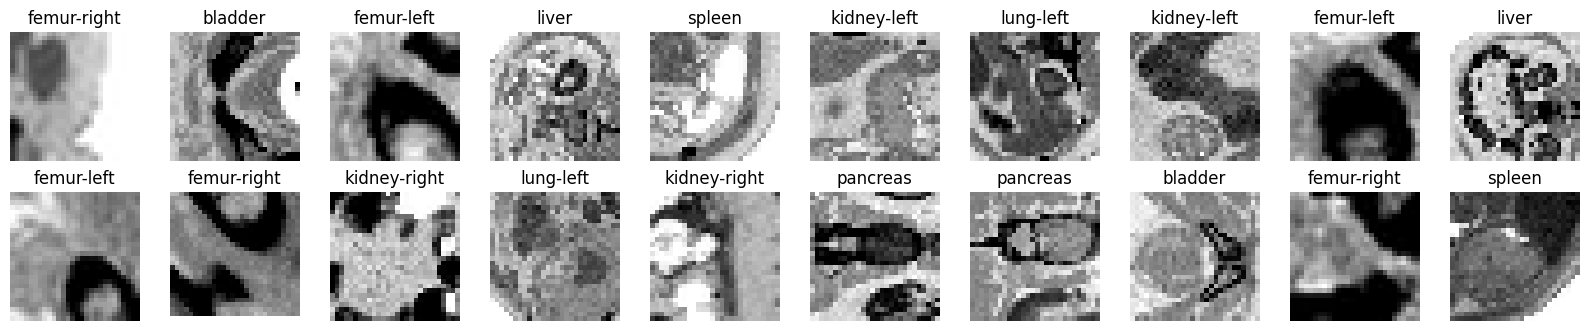

In [6]:
import matplotlib.pyplot as plt
nrows = 2; ncols = 10
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16*nrows/ncols), constrained_layout=True)
for ax, x, y in zip(axs.flat, X_train, y_train):
  ax.set_axis_off(); image = (x[:,:,0]*255).astype(np.uint8); ax.set_title(labels[y[0]])
  ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none")


Esta vez sí que tendremos en cuenta la partición de validación. Sin embargo, en este paso aplanamos las imágenes en un vector de 28x28x28 dimensiones.

In [7]:
input_dim = 28*28*28

x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32).reshape(x.shape[0], input_dim); y_train = np.squeeze(y.astype(np.uint8))

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32).reshape(x.shape[0], input_dim); y_val = np.squeeze(y.astype(np.uint8))

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32).reshape(x.shape[0], input_dim); y_test = np.squeeze(y.astype(np.uint8))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

labels = list(train_dataset.info["label"].values())
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(971, 21952) (971, 11) (161, 21952) (161, 11) (610, 21952) (610, 11)


Automatización de la función de muestra de la Confusion Matrix.

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
np.set_printoptions(precision=2)
def print_cm(model):
  y_pred = model.predict(X_test).argmax(axis = 1)
  y_true = y_test.argmax(axis = 1)

  disp = ConfusionMatrixDisplay.from_predictions(
          y_true,
          y_pred,
          display_labels=labels,
          cmap=plt.cm.Blues,
          normalize="true",
      )
  disp.ax_.set_title("Confusion Matrix")
  fig = disp.ax_.get_figure()
  fig.set_figwidth(15)
  fig.set_figheight(15)

  disp = ConfusionMatrixDisplay.from_predictions(
          y_true,
          y_pred,
          display_labels=labels,
          cmap=plt.cm.Reds,
          normalize="pred",
      )
  disp.ax_.set_title("Confusion Matrix")
  fig = disp.ax_.get_figure()
  fig.set_figwidth(15)
  fig.set_figheight(15)

# Red neuronal simple (MLP)



En primer lugar probaré con un MLP muy sencillo para evaluar los resultados.

In [8]:
M = keras.Sequential([keras.Input(shape=(input_dim,)),
                      keras.layers.Dense(800, activation='relu'),
                      keras.layers.Dense(num_classes, activation='softmax')])
M.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 800)                 │      17,562,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │           8,811 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,571,211 (67.03 MB)

 Trainable params: 17,571,211 (67.03 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
M.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [10]:
H = M.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=16, epochs=20, verbose=1)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.2125 - loss: 20.6494 - val_accuracy: 0.7081 - val_loss: 0.8980
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6164 - loss: 1.9699 - val_accuracy: 0.7453 - val_loss: 1.0427
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7028 - loss: 1.1750 - val_accuracy: 0.7640 - val_loss: 1.3512
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6964 - loss: 1.6967 - val_accuracy: 0.7888 - val_loss: 1.0433
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7111 - loss: 1.0821 - val_accuracy: 0.8385 - val_loss: 1.2370
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7982 - loss: 0.8467 - val_accuracy: 0.9130 - val_loss: 0.2589
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8132 - loss: 0.6190 - val_accuracy: 0.8944 - val_loss: 0.3663
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8396 - loss: 0.5136 - val_accuracy: 0.9130 - val_

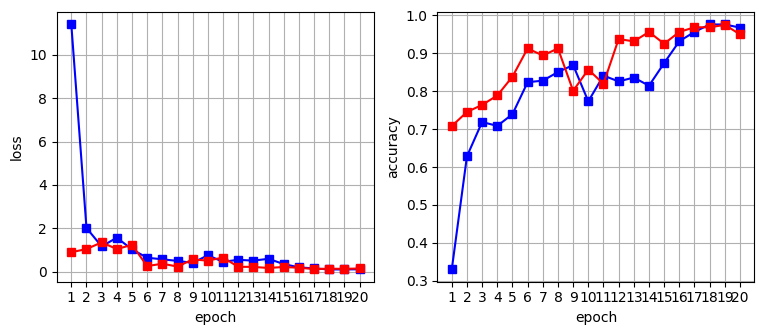

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.set_xticks(xx); ax.plot(xx, H.history['loss'], color='b', marker='s'); ax.plot(xx, H.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.set_xticks(xx); ax.plot(xx, H.history['accuracy'], color='b', marker='s'); ax.plot(xx, H.history['val_accuracy'], color='r', marker='s')

In [12]:
score = M.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.1%}')

Loss: 1.086
Precisión: 72.1%


No parece haber sobreentrenamiento con los datos de validación, pero aún así sí que hay una gran diferencia con el rendimiento en test.

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


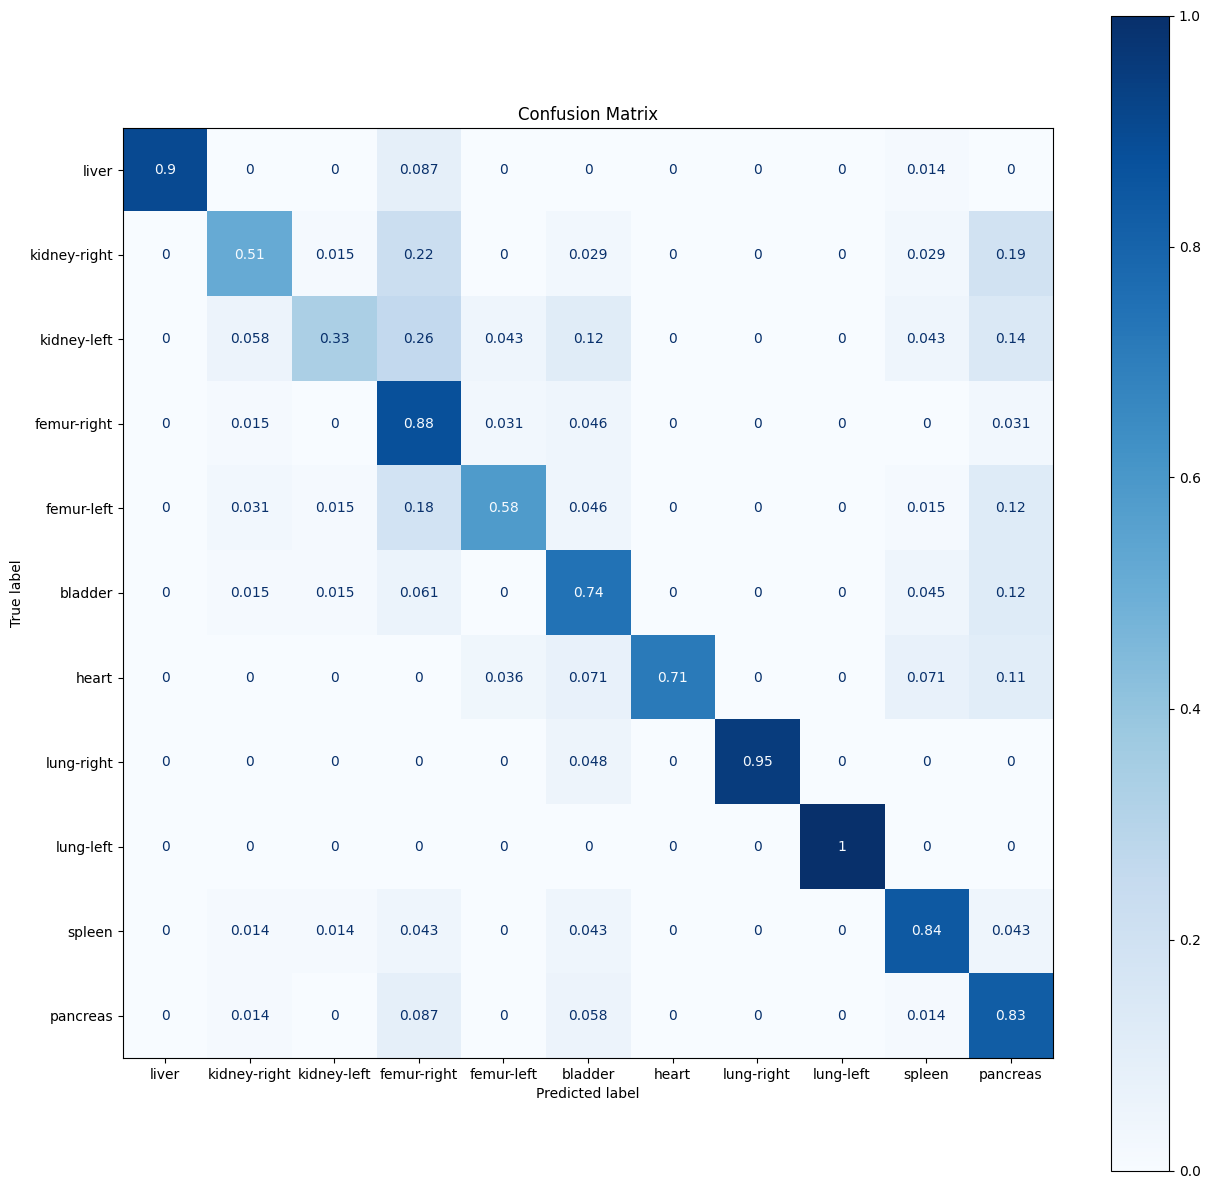

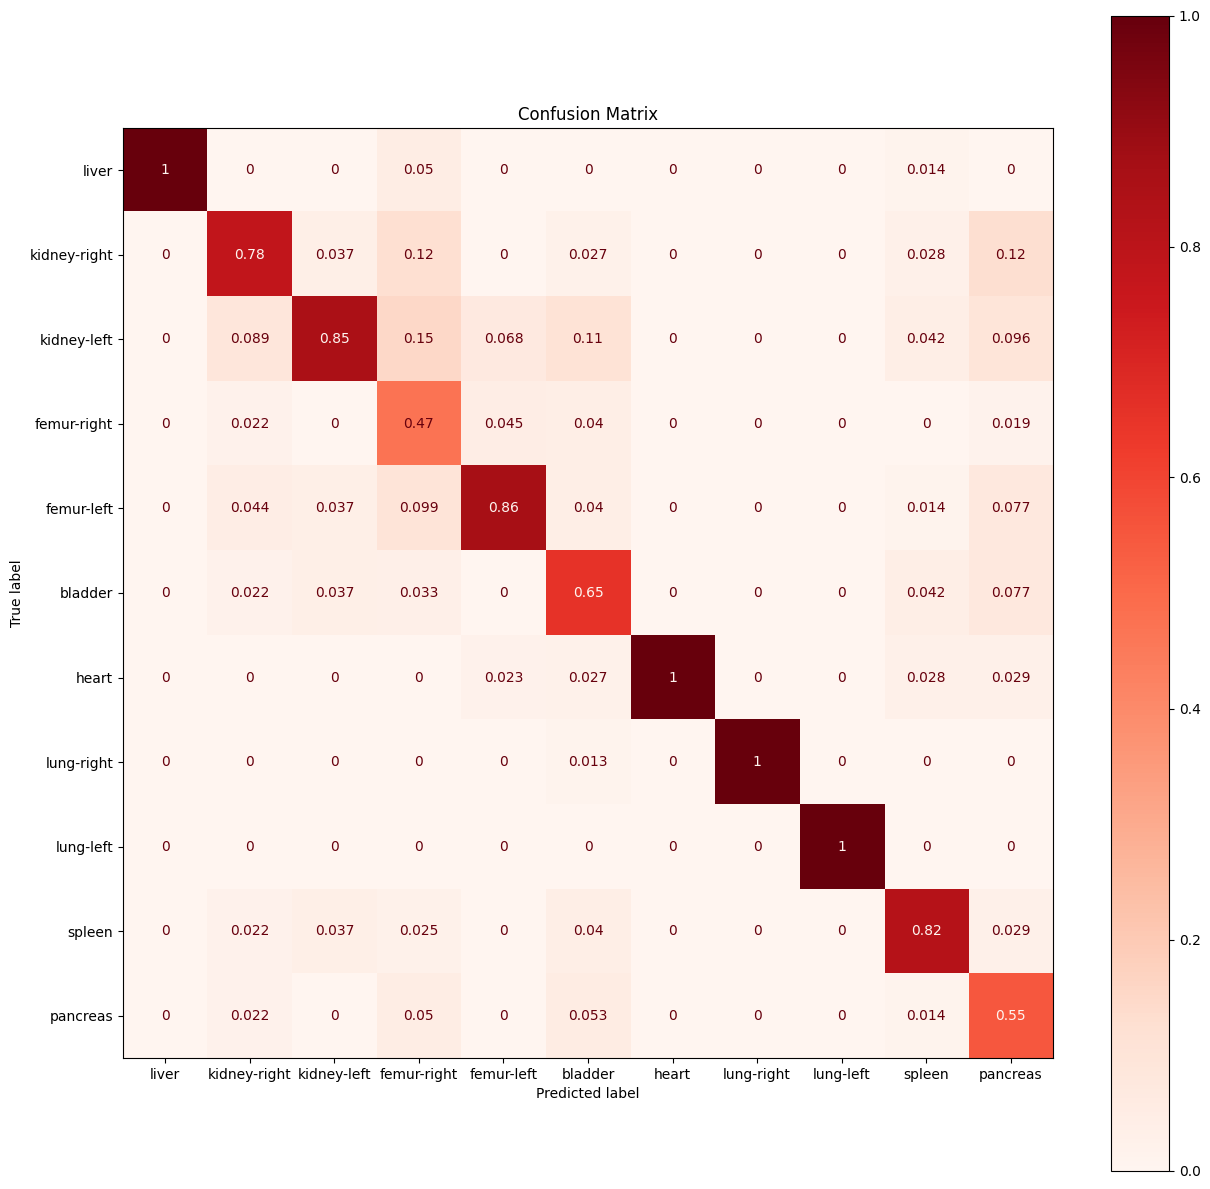

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
np.set_printoptions(precision=2)

y_pred = M.predict(X_test).argmax(axis = 1)
y_true = y_test.argmax(axis = 1)

disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=labels,
        cmap=plt.cm.Blues,
        normalize="true",
    )
disp.ax_.set_title("Confusion Matrix")
fig = disp.ax_.get_figure()
fig.set_figwidth(15)
fig.set_figheight(15)

disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=labels,
        cmap=plt.cm.Reds,
        normalize="pred",
    )
disp.ax_.set_title("Confusion Matrix")
fig = disp.ax_.get_figure()
fig.set_figwidth(15)
fig.set_figheight(15)

# Keras Tuner

Ahora trabajaremos tuneando distintas arquitecturas.

In [8]:
!pip install keras_tuner --upgrade --quiet
import keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.4 MB/s eta 0:00:00


In [15]:
def build_model(hp):
  M = keras.Sequential()
  M.add(keras.Input(shape=(input_dim,)))
  for L in range(hp.Int("num_layers", 1, 3)):
    M.add(keras.layers.Dense(
          units=hp.Int(f"units_{L}", min_value=700, max_value=900, step=100),
          activation='relu'))
  M.add(keras.layers.Dense(num_classes, activation='softmax'))
  M.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  return M

In [16]:
tuner = keras_tuner.BayesianOptimization(
  hypermodel=build_model, # función para construir un modelo
  objective="val_accuracy", # objetivo a optimizar
  max_trials=10, # máximo número de experimentos (trials) a realizar
  executions_per_trial=1, # modelos a crear, entrenar y evaluar por cada trial
  overwrite=True, # para reinicializar o continuar una búsqueda previa
  directory="/tmp", # directorio para guardar los resultados del ajuste
  project_name="OrganMNIST3D", # subdirectorio dentro de directory
)


In [18]:
tuner.search(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_val, y_val))

Trial 10 Complete [00h 00m 15s]
val_accuracy: 0.9068322777748108

Best val_accuracy So Far: 0.9813664555549622
Total elapsed time: 00h 02m 29s


In [19]:
tuner.results_summary(num_trials=1)

Results summary
Results in /tmp/OrganMNIST3D
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
num_layers: 1
units_0: 900
units_1: 800
units_2: 900
Score: 0.9813664555549622


In [21]:
best = tuner.get_best_models(num_models=1)[0]
score = best.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.1%}')

Loss: 0.9627
Precisión: 72.3%


El modelo mejora en un 0.2% (alrededor de 2 imágenes mejor clasificadas).

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


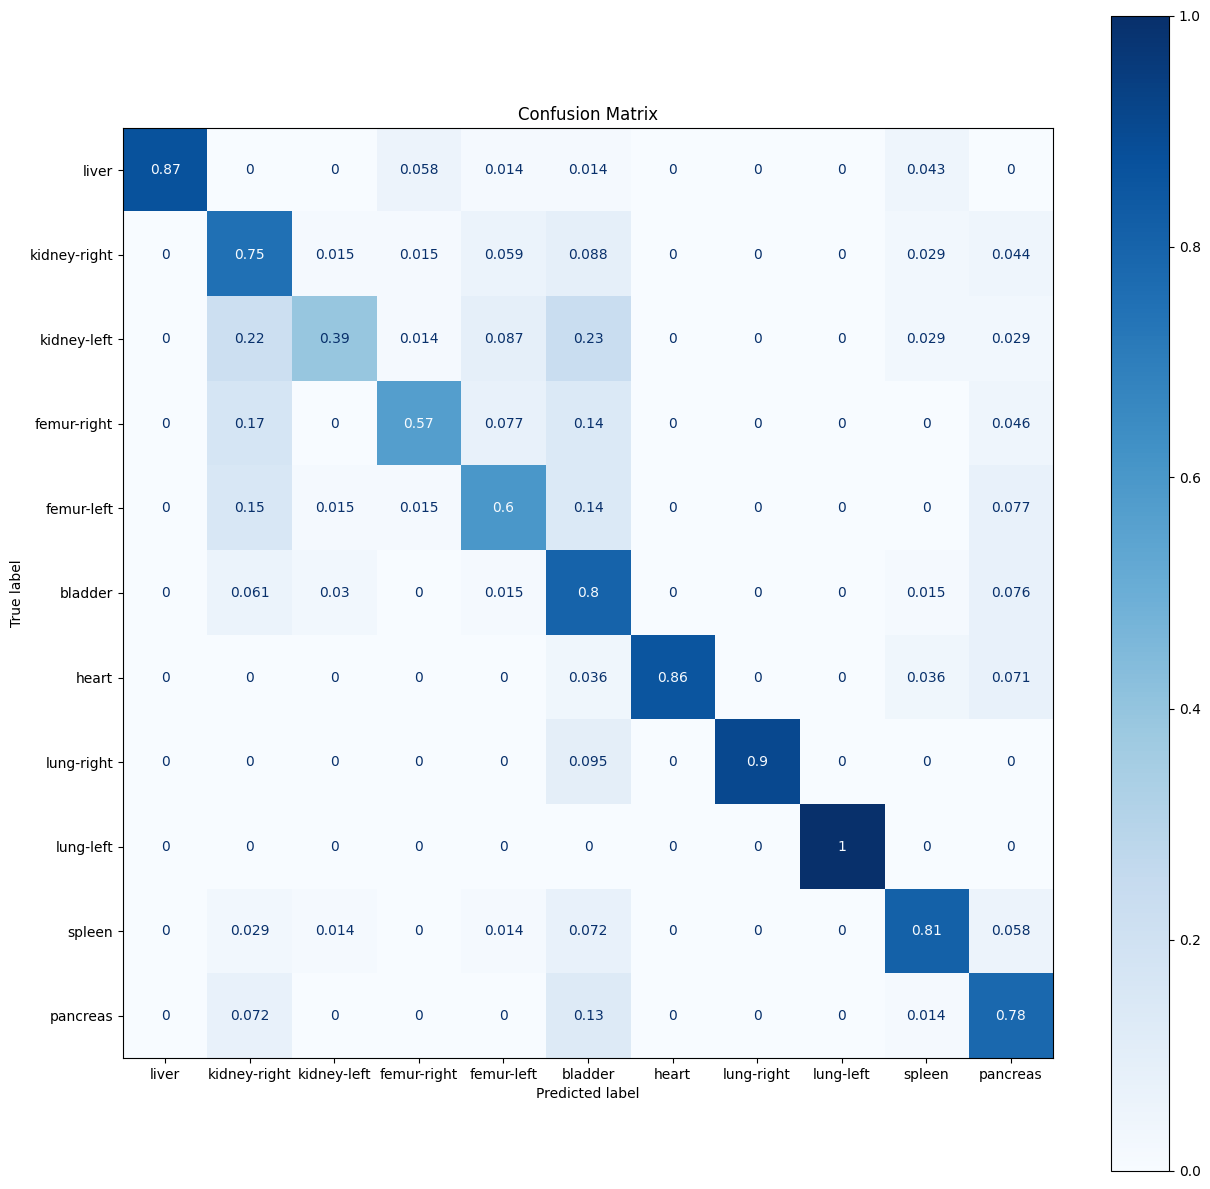

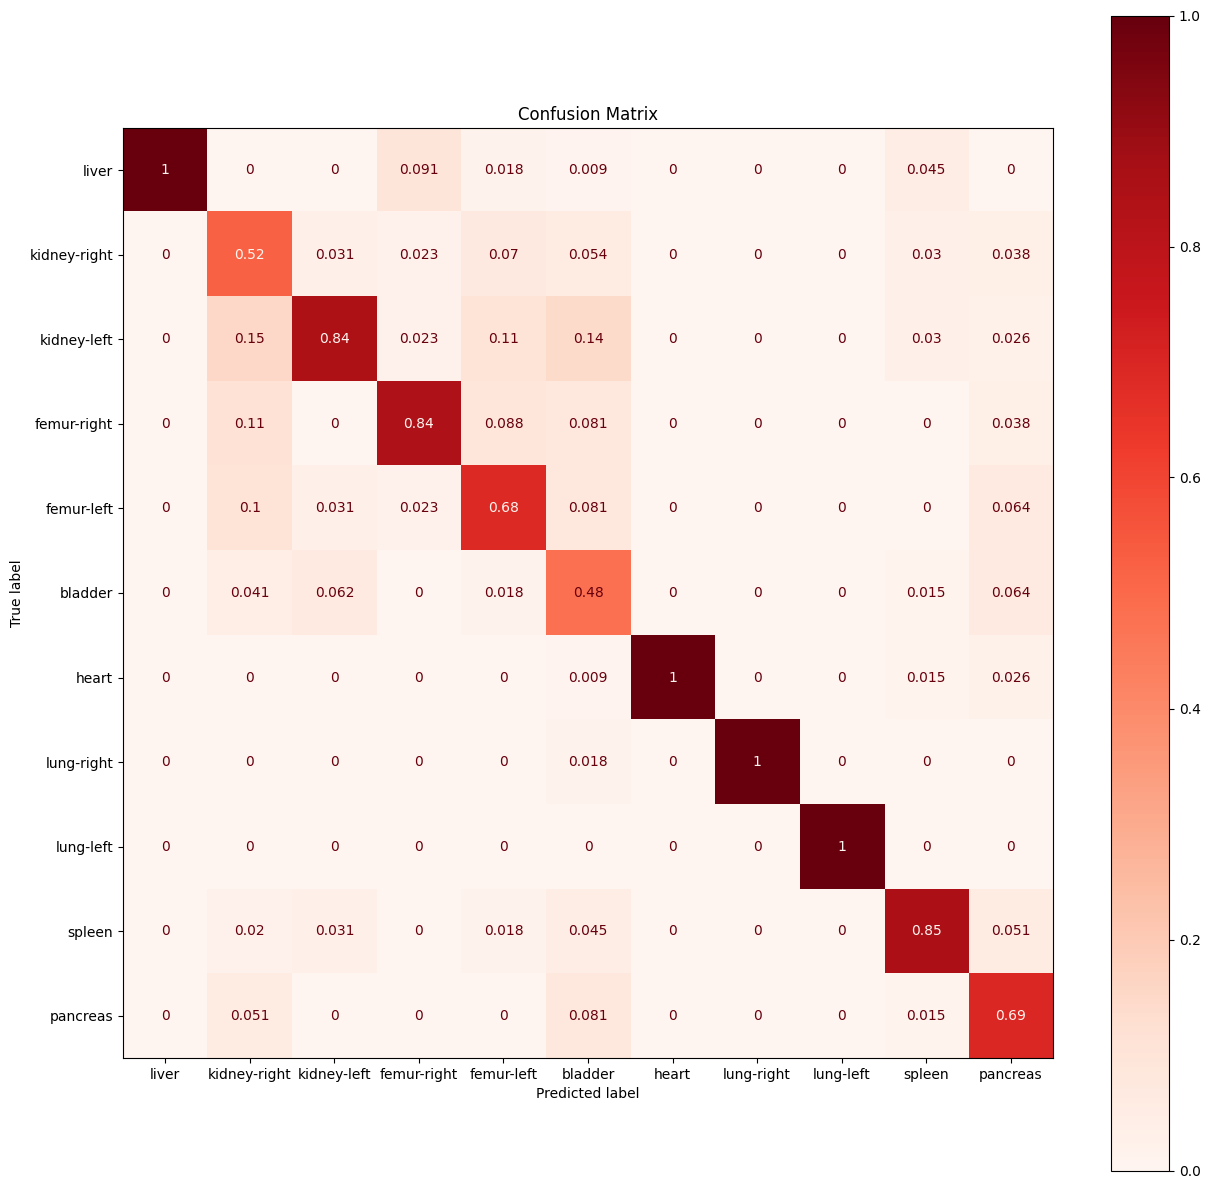

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay
np.set_printoptions(precision=2)

y_pred = best.predict(X_test).argmax(axis = 1)
y_true = y_test.argmax(axis = 1)

disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=labels,
        cmap=plt.cm.Blues,
        normalize="true",
    )
disp.ax_.set_title("Confusion Matrix")
fig = disp.ax_.get_figure()
fig.set_figwidth(15)
fig.set_figheight(15)

disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=labels,
        cmap=plt.cm.Reds,
        normalize="pred",
    )
disp.ax_.set_title("Confusion Matrix")
fig = disp.ax_.get_figure()
fig.set_figwidth(15)
fig.set_figheight(15)

In [9]:
X_train_val, y_train_val = np.concatenate((X_train, X_val), axis=0), np.concatenate((y_train, y_val), axis=0)

In [35]:
M = build_model(tuner.get_best_hyperparameters(1)[0])
H = M.fit(X_train_val, y_train_val, batch_size=16, epochs=10, verbose=0)

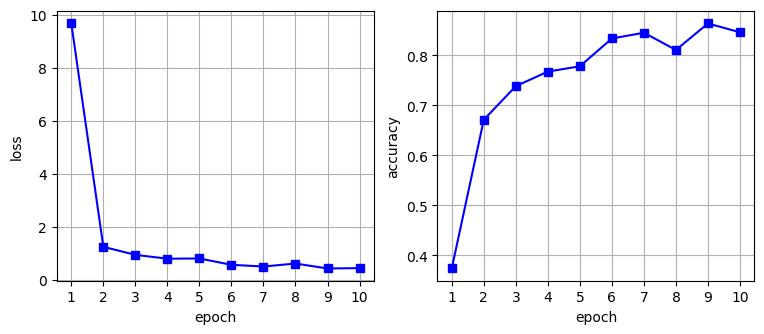

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.set_xticks(xx); ax.plot(xx, H.history['loss'], color='b', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.set_xticks(xx); ax.plot(xx, H.history['accuracy'], color='b', marker='s')

In [38]:
score = M.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.1%}')

Loss: 0.9758
Precisión: 70.7%


El reentrenamiento con los datos de validación hace descender el rendimiento.

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


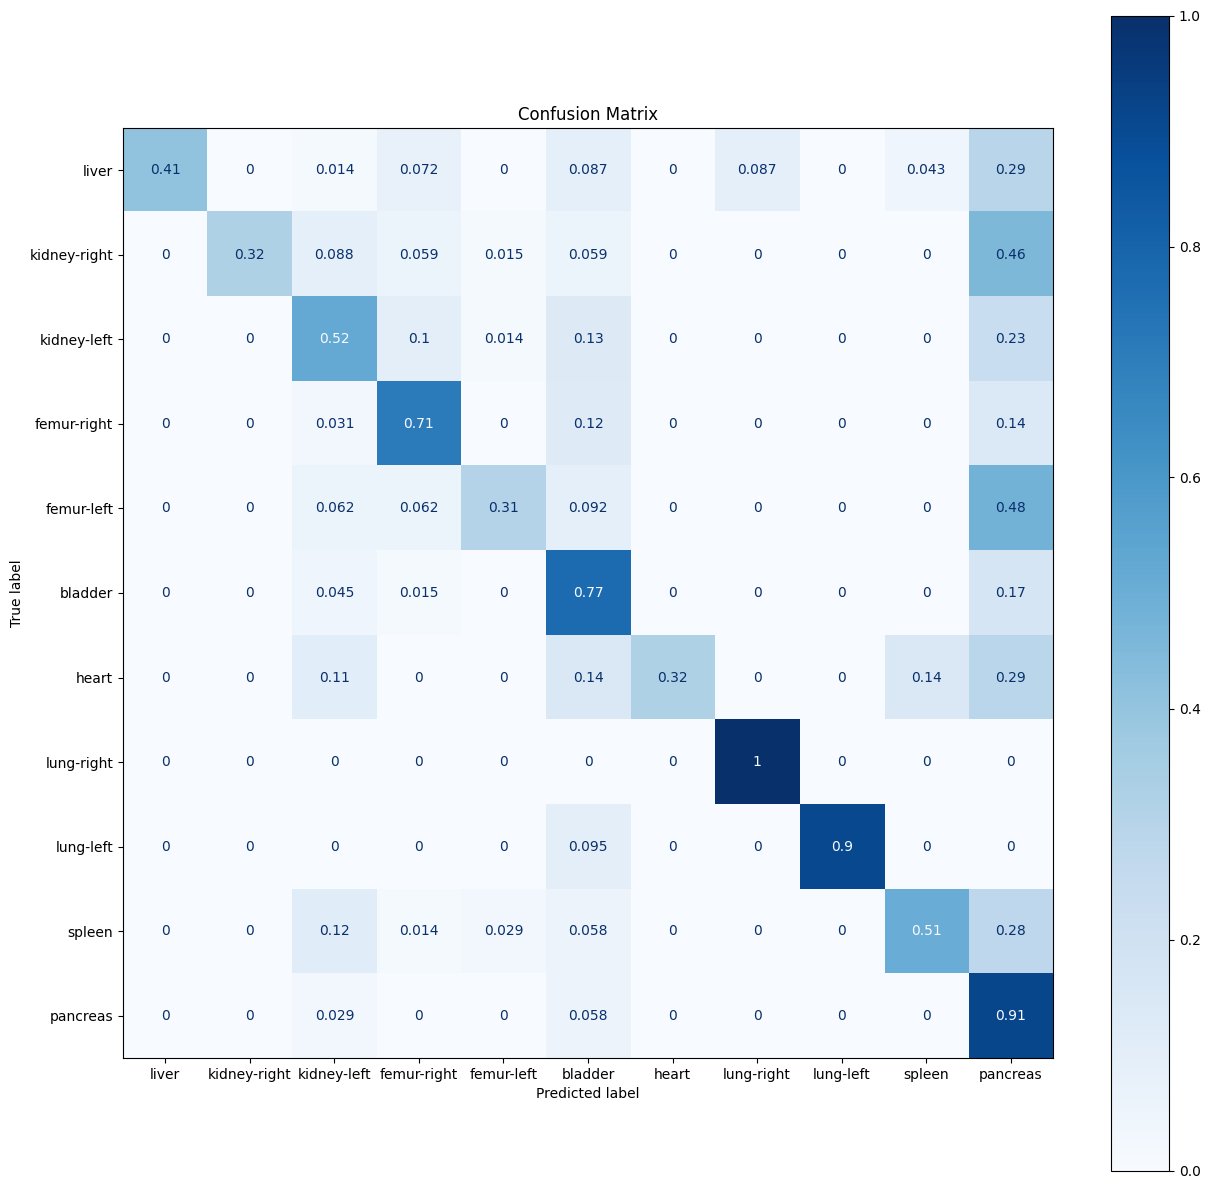

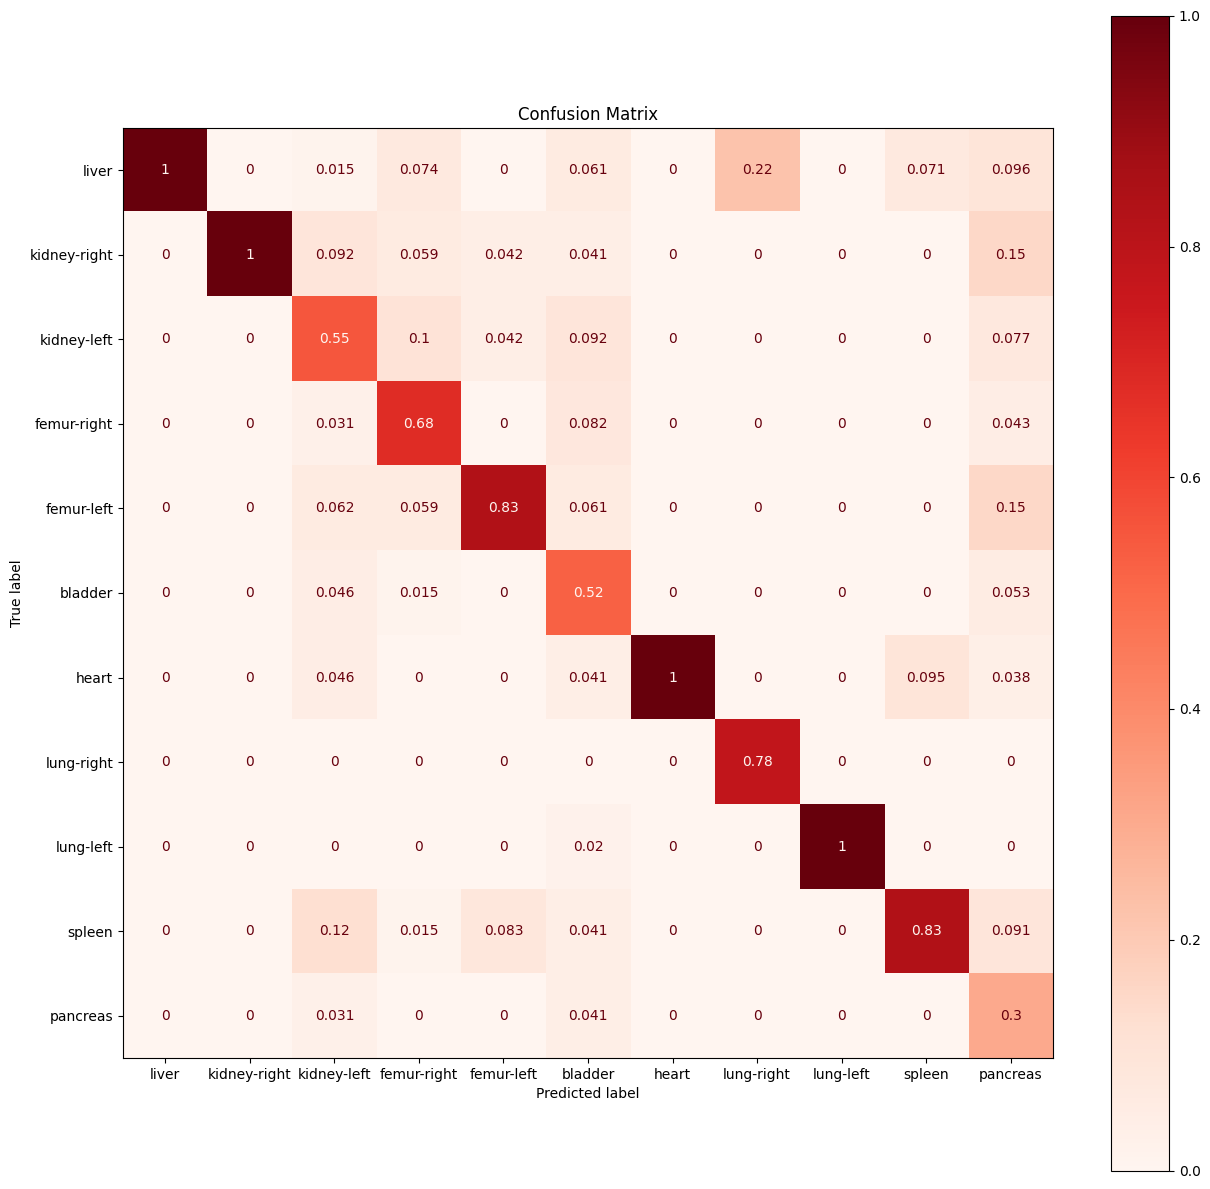

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
np.set_printoptions(precision=2)

y_pred = M.predict(X_test).argmax(axis = 1)
y_true = y_test.argmax(axis = 1)

disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=labels,
        cmap=plt.cm.Blues,
        normalize="true",
    )
disp.ax_.set_title("Confusion Matrix")
fig = disp.ax_.get_figure()
fig.set_figwidth(15)
fig.set_figheight(15)

disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=labels,
        cmap=plt.cm.Reds,
        normalize="pred",
    )
disp.ax_.set_title("Confusion Matrix")
fig = disp.ax_.get_figure()
fig.set_figwidth(15)
fig.set_figheight(15)

# Learning rate (regularization) and Batch Size

En este siguiente paso tunearé los hiperparámetros del modelo para conseguir la mejor combinación.

In [61]:
class MyHyperModel(keras_tuner.HyperModel):
  def build(self, hp):
    M = keras.Sequential()
    M.add(keras.Input(shape=(input_dim,)))
    M.add(keras.layers.Dense(units=900, activation='relu'))
    M.add(keras.layers.Dense(num_classes, activation='softmax'))
    learning_rate = hp.Float("lr", min_value=0.0015, max_value=0.0019)
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return M
  def fit(self, hp, M, x, y, xy_val, **kwargs):
    bs = hp.Int("batch_size", 64, 1024, step=2, sampling="log")
    early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-5)
    kwargs['callbacks'].append(early_cb)
    return M.fit(x, y, batch_size=bs, epochs=100, validation_data=xy_val, **kwargs)

In [63]:
tuner = keras_tuner.BayesianOptimization(
 MyHyperModel(), objective="val_accuracy", max_trials=5,
 overwrite=True, directory="/tmp", project_name="OrganMNIST3D")

In [64]:
tuner.search(X_train, y_train, (X_val, y_val))

Trial 5 Complete [00h 01m 05s]
val_accuracy: 0.9689440727233887

Best val_accuracy So Far: 0.9875776171684265
Total elapsed time: 00h 03m 21s


In [65]:
tuner.results_summary(num_trials=1)

Results summary
Results in /tmp/OrganMNIST3D
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
lr: 0.001619276131515413
batch_size: 128
Score: 0.9875776171684265


In [66]:
best = tuner.get_best_models(num_models=1)[0]
score = best.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

Loss: 0.8479
Precisión: 73.77%


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


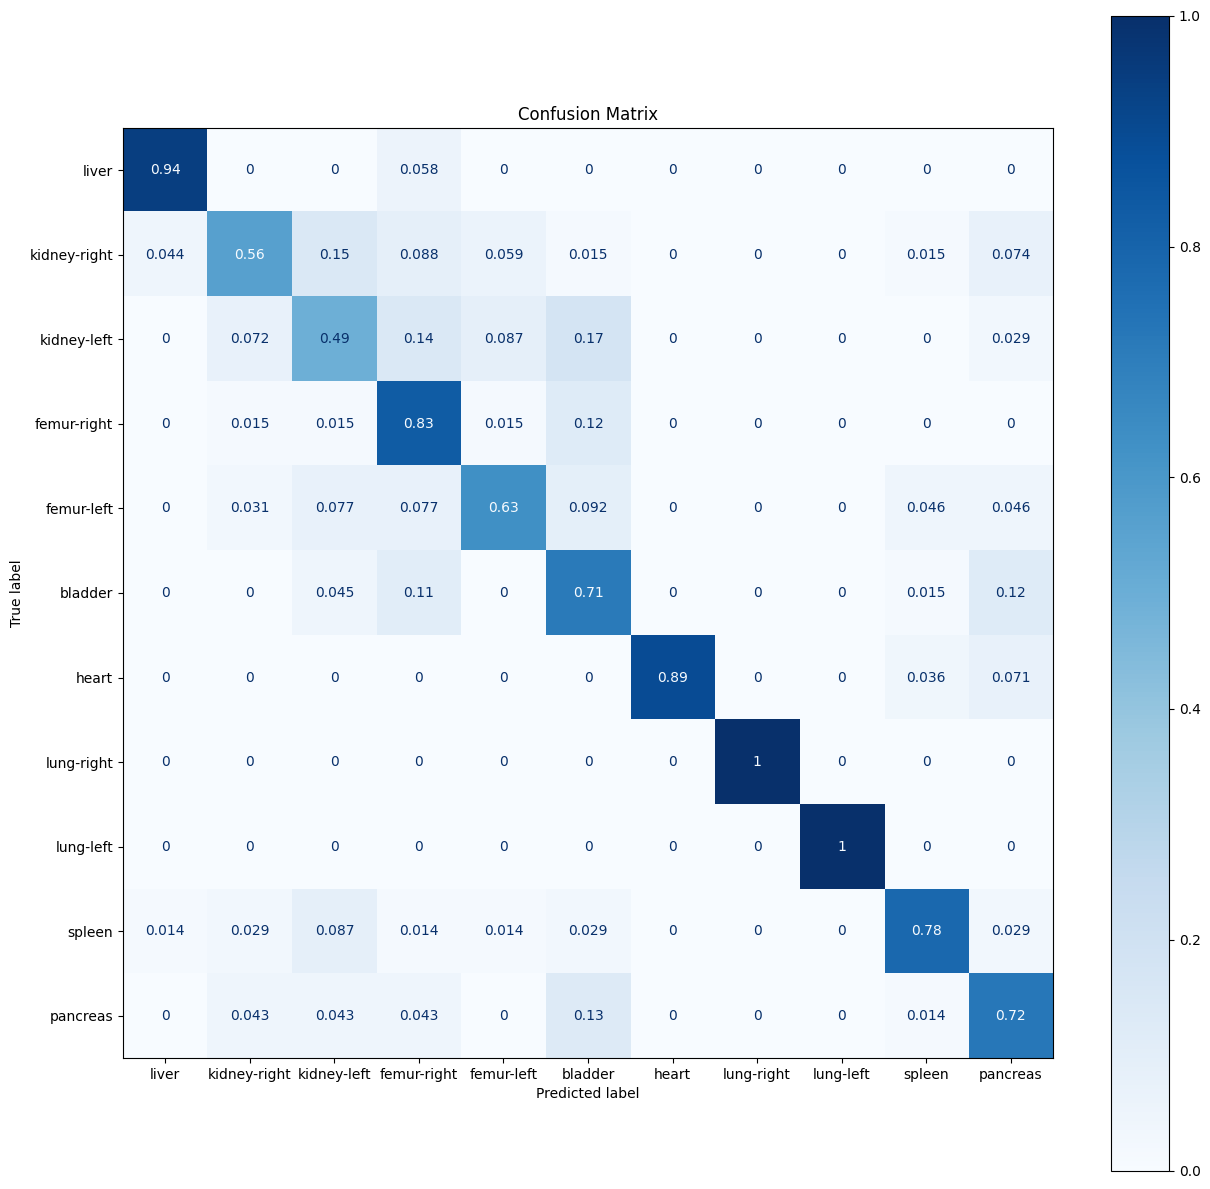

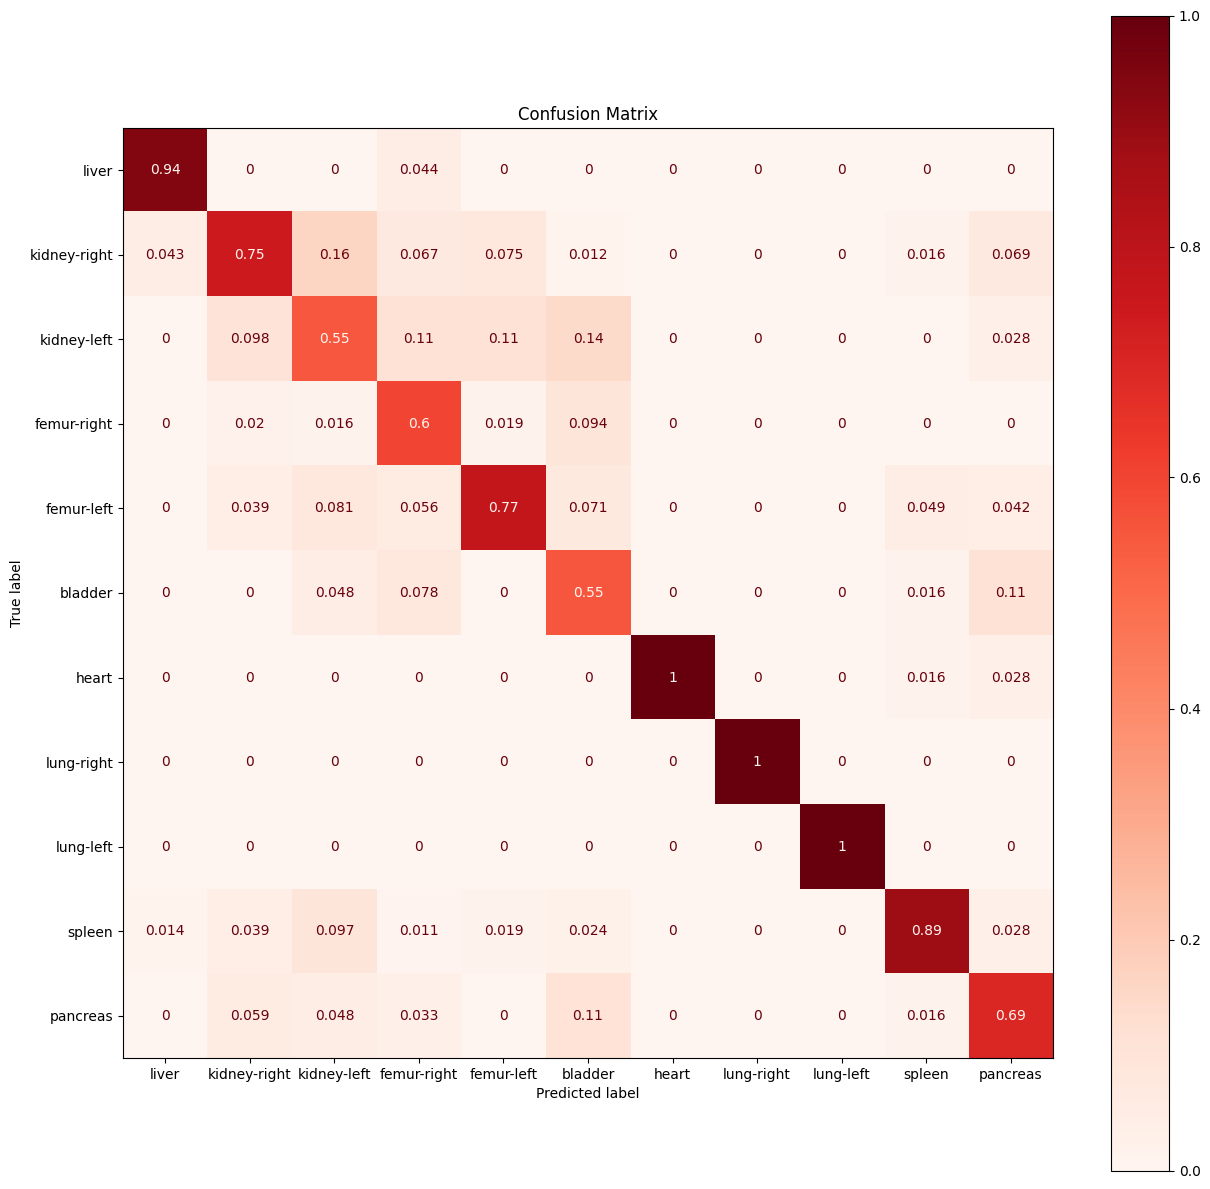

In [67]:
y_pred = best.predict(X_test).argmax(axis = 1)
y_true = y_test.argmax(axis = 1)

disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=labels,
        cmap=plt.cm.Blues,
        normalize="true",
    )
disp.ax_.set_title("Confusion Matrix")
fig = disp.ax_.get_figure()
fig.set_figwidth(15)
fig.set_figheight(15)

disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=labels,
        cmap=plt.cm.Reds,
        normalize="pred",
    )
disp.ax_.set_title("Confusion Matrix")
fig = disp.ax_.get_figure()
fig.set_figwidth(15)
fig.set_figheight(15)

In [69]:
opt = keras.optimizers.Adam(learning_rate=0.001)
best.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = best.fit(X_train_val, y_train_val, batch_size=128, epochs=10, validation_data=(X_test, y_test), verbose=0)
score = best.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

Loss: 0.7939
Precisión: 74.43%


¡Un 2% de mejora! Alrededor de 20 imágenes mejor clasificadas, es un buen avance aunque aún no se supera a QDA.

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


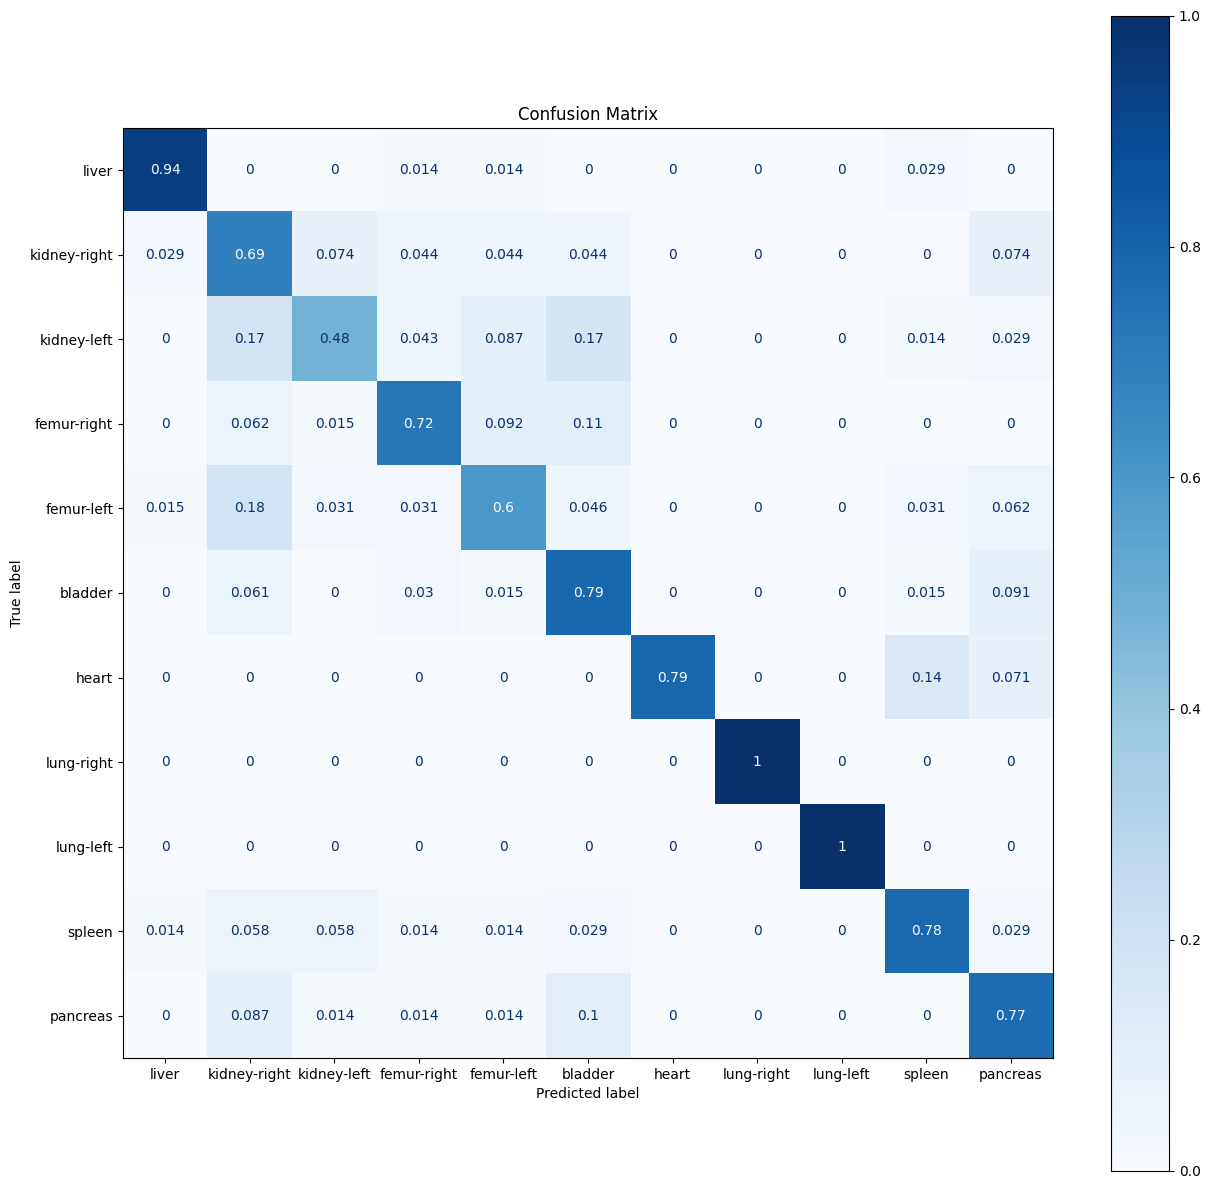

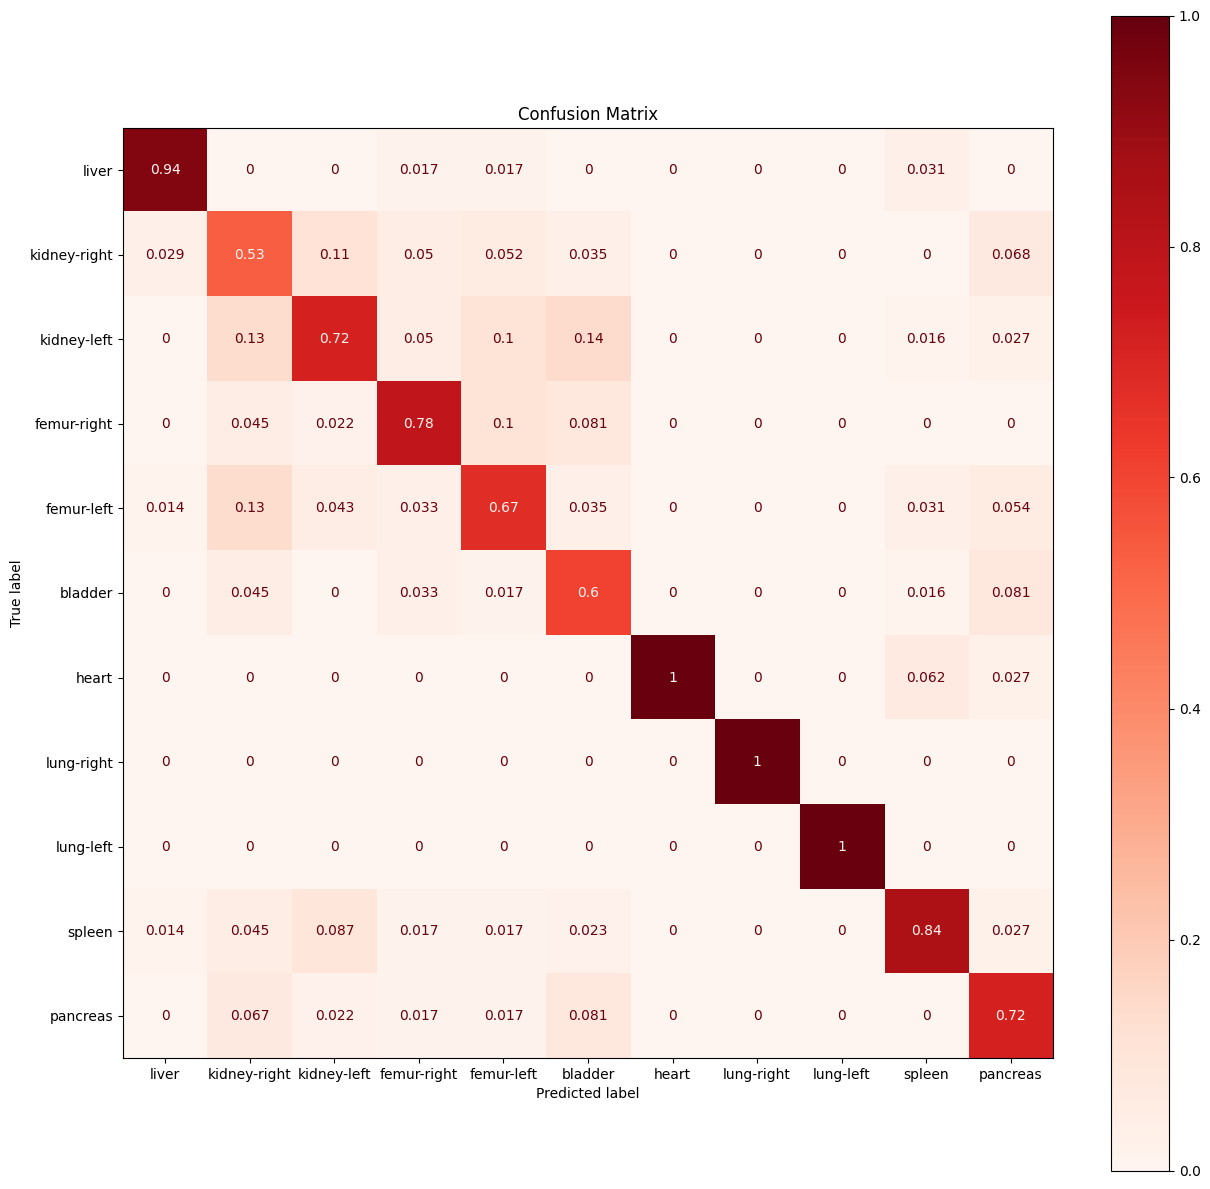

In [70]:
y_pred = best.predict(X_test).argmax(axis = 1)
y_true = y_test.argmax(axis = 1)

disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=labels,
        cmap=plt.cm.Blues,
        normalize="true",
    )
disp.ax_.set_title("Confusion Matrix")
fig = disp.ax_.get_figure()
fig.set_figwidth(15)
fig.set_figheight(15)

disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=labels,
        cmap=plt.cm.Reds,
        normalize="pred",
    )
disp.ax_.set_title("Confusion Matrix")
fig = disp.ax_.get_figure()
fig.set_figwidth(15)
fig.set_figheight(15)

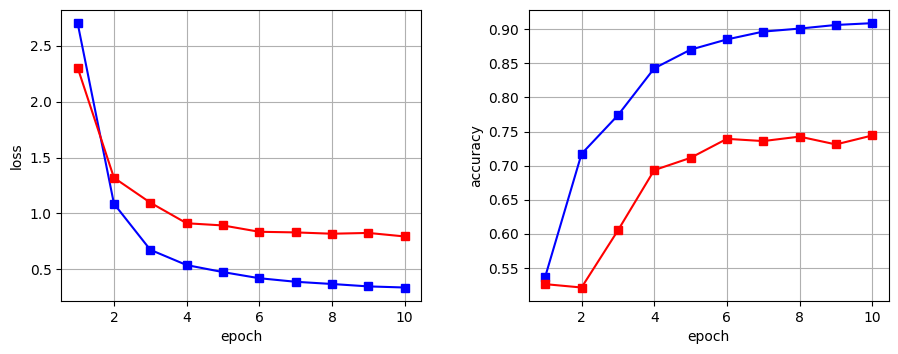

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, H.history['loss'], color='b', marker='s')
ax.plot(xx, H.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, H.history['accuracy'], color='b', marker='s')
ax.plot(xx, H.history['val_accuracy'], color='r', marker='s');


A continuación incluimos el Scheduler del Learning Rate de Reduce On Plateau.

In [10]:
class MyHyperModel(keras_tuner.HyperModel):
  def build(self, hp):
    M = keras.Sequential()
    M.add(keras.Input(shape=(input_dim,)))
    M.add(keras.layers.Dense(units=900, activation='relu'))
    M.add(keras.layers.Dense(num_classes, activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=0.001619)
    M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return M
  def fit(self, hp, M, x, y, xy_val, **kwargs):
    factor = hp.Float("factor", min_value=0.1, max_value=0.5)
    patience = hp.Choice("patience", [2, 5, 10])
    reduce_cb = keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', factor=factor, patience=patience, min_delta=1e-4, min_lr=1e-5)
    early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2*patience, min_delta=1e-5)
    kwargs['callbacks'].extend([reduce_cb, early_cb])
    return M.fit(x, y, batch_size=128, epochs=100, validation_data=xy_val, **kwargs)

In [11]:
tuner = keras_tuner.BayesianOptimization(
 MyHyperModel(), objective="val_accuracy", max_trials=10,
 overwrite=True, directory="/tmp", project_name="OrganMNIST3D")

In [12]:
tuner.search(X_train, y_train, (X_val, y_val))

Trial 10 Complete [00h 00m 27s]
val_accuracy: 0.9813664555549622

Best val_accuracy So Far: 0.9937888383865356
Total elapsed time: 00h 06m 42s


In [13]:
tuner.results_summary(num_trials=1)

Results summary
Results in /tmp/OrganMNIST3D
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
factor: 0.3133591361613539
patience: 10
Score: 0.9937888383865356


In [23]:
best = tuner.get_best_models(num_models=1)[0]
score = best.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

Loss: 0.7698
Precisión: 77.21%


Otra mejora del 3%, ya superando a QDA. Se imponen las redes neuronales.

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


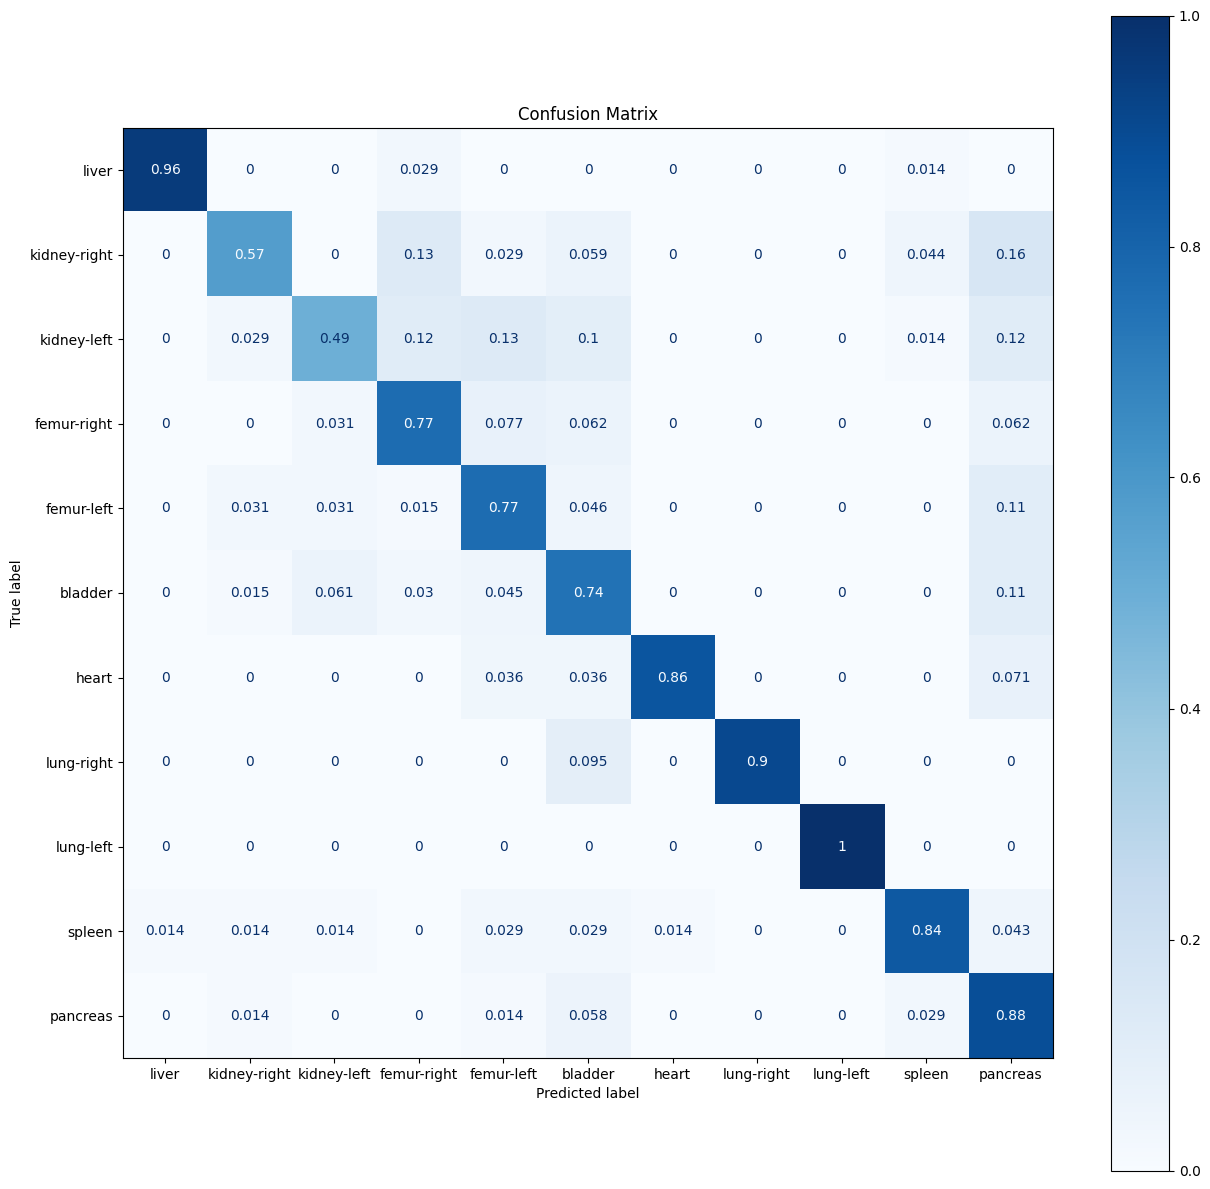

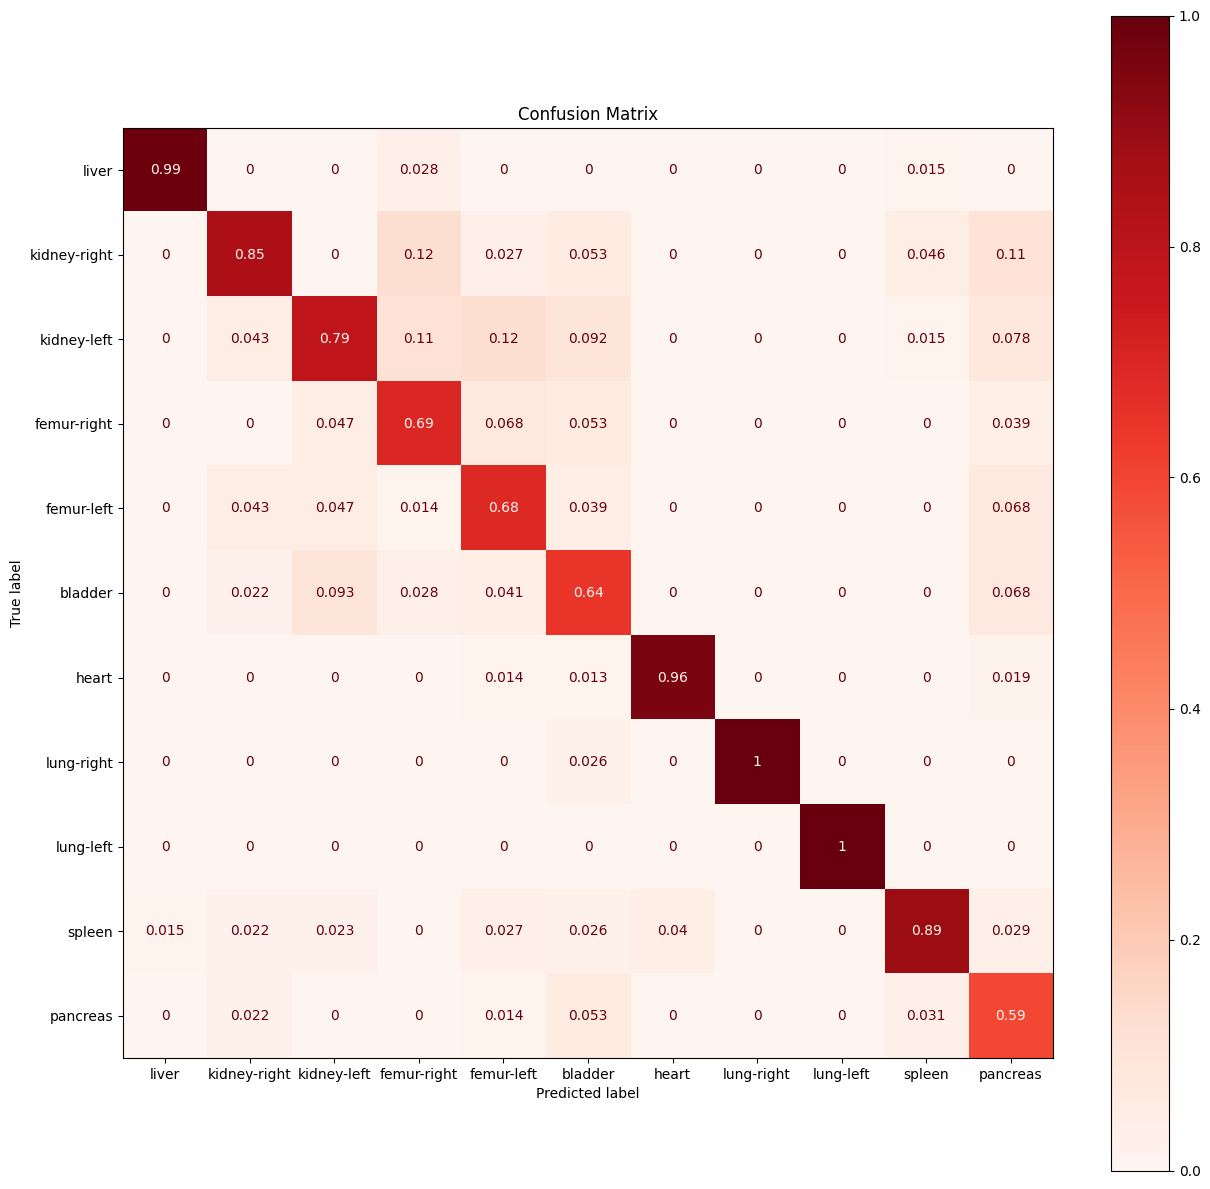

In [18]:
print_cm(best)

In [24]:
opt = keras.optimizers.Adam(learning_rate=0.001)
best.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = best.fit(X_train_val, y_train_val, batch_size=128, epochs=10, validation_data=(X_test, y_test), verbose=0)
score = best.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

Loss: 0.7168
Precisión: 76.56%


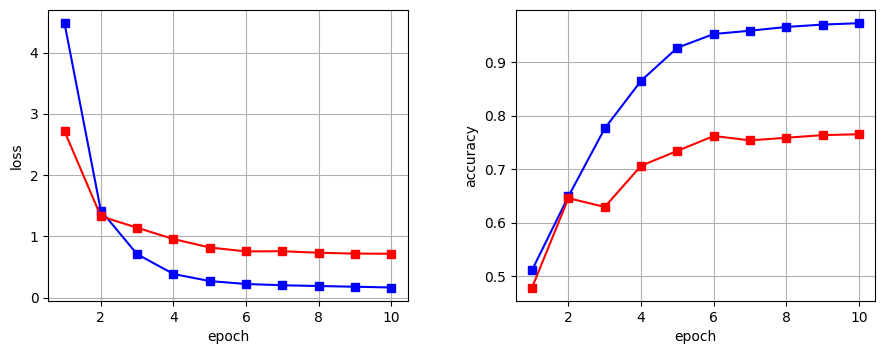

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, H.history['loss'], color='b', marker='s')
ax.plot(xx, H.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, H.history['accuracy'], color='b', marker='s')
ax.plot(xx, H.history['val_accuracy'], color='r', marker='s');

Comienza a apreciarse bien el sobreentrenamiento, acercándonos ya al 100% de acierto en test pero sin llegar al 80% en validación y test. Sin embargo, las métricas de validación y test se empiezan a asemejar en gran medida. Seguimos observando que las categorías de los riñones izquierdo y derecho son las que producen mayores problemas en la clasificación.